### 数据处理

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import MCM

sum_days = 4
test_start = 4910
test_end = 5105 #Excel中的行数-2

data = pd.read_csv('bigger_Wimbledon_featured_matches.csv')
num_data = data.copy()
num_data['elapsed_time'] = pd.to_timedelta(num_data['elapsed_time']).dt.total_seconds()
num_data['cost_time'] = num_data['elapsed_time'] - num_data['elapsed_time'].shift(1)
num_data['p1_get_point'] = (num_data['point_victor'] == 1).astype(int)
num_data['p2_get_point'] = (num_data['point_victor'] == 2).astype(int)
num_data['p1_score'] = num_data['p1_score'].apply(
    lambda x: 0 if x=='0' else
              1 if x=='15' else
              2 if x=='30' else
              3 if x=='40' else 4)#AD
num_data['p2_score'] = num_data['p2_score'].apply(
    lambda x: 0 if x=='0' else
              1 if x=='15' else
              2 if x=='30' else
              3 if x=='40' else 4)#AD
num_data['winner_shot_type'] = num_data['winner_shot_type'].apply(
    lambda x: -1 if x=='B' else
               1 if x=='F' else 0)#0
num_data['speed_mph'] = num_data['speed_mph'].apply(
    lambda x: x if x>=1 and x <= 300 else num_data['speed_mph'].mean())
num_data['serve_width_1'] = num_data['serve_width'].apply(
    lambda x: 1 if x=='BC' or x=='BW' or x=='B' else 0)#NA,C,W
num_data['serve_width_2'] = num_data['serve_width'].apply(
    lambda x: -1 if x=='BC' or x=='C' else
               1 if x=='BW' or x=='W' else 0)#NA,B
num_data['serve_depth'] = num_data['serve_depth'].apply(
    lambda x: -1 if x=='NCTL' else
               1 if x=='CTL'  else 0)#NA
num_data['return_depth'] = num_data['return_depth'].apply(
    lambda x: -1 if x=='ND' else
               1 if x=='D'  else 0)#NA
num_columns = num_data.columns.to_list()
num_columns.remove('match_id')
num_columns.remove('elapsed_time')
num_columns.remove('player1')
num_columns.remove('player2')
num_columns.remove('serve_width')
num_data = num_data[num_columns]

dict_data = MCM.load('bigger-weight-save-2024-02-03-09-02-18.json')
dict_data['p1_m_avg'] = np.array(dict_data['p1_m_avg'])
dict_data['p2_m_avg'] = np.array(dict_data['p2_m_avg'])
dict_data['p1_m_gaussian'] = np.array(dict_data['p1_m_gaussian'])
dict_data['p2_m_gaussian'] = np.array(dict_data['p2_m_gaussian'])

train_data = num_data[0:test_end].copy()
for i in range(1,sum_days):
    train_data = train_data + num_data[i:test_end+i].reset_index(drop=True)
train_data['p1_m_avg'] = dict_data['p1_m_avg'][sum_days-1:test_end+sum_days-1]
train_data['p2_m_avg'] = dict_data['p2_m_avg'][sum_days-1:test_end+sum_days-1]
train_data['p1_m_gaussian'] = dict_data['p1_m_gaussian'][sum_days-1:test_end+sum_days-1]
train_data['p2_m_gaussian'] = dict_data['p2_m_gaussian'][sum_days-1:test_end+sum_days-1]
train_data['p1_next_m_avg'] = dict_data['p1_m_avg'][sum_days:test_end+sum_days]
train_data['p2_next_m_avg'] = dict_data['p2_m_avg'][sum_days:test_end+sum_days]
train_data['p1_next_m_gaussian'] = dict_data['p1_m_gaussian'][sum_days:test_end+sum_days]
train_data['p2_next_m_gaussian'] = dict_data['p2_m_gaussian'][sum_days:test_end+sum_days]
train_data['p1_avg_diff'] = dict_data['p1_m_avg'][sum_days:test_end+sum_days]-dict_data['p1_m_avg'][sum_days-1:test_end+sum_days-1]
train_data['p2_avg_diff'] = dict_data['p2_m_avg'][sum_days:test_end+sum_days]-dict_data['p2_m_avg'][sum_days-1:test_end+sum_days-1]
train_data['p1_gaussian_diff'] = dict_data['p1_m_gaussian'][sum_days:test_end+sum_days]-dict_data['p1_m_gaussian'][sum_days-1:test_end+sum_days-1]
train_data['p2_gaussian_diff'] = dict_data['p2_m_gaussian'][sum_days:test_end+sum_days]-dict_data['p2_m_gaussian'][sum_days-1:test_end+sum_days-1]
i = test_end-2
last_end = test_end-1
another_start= 2673
another_end = 2948
while i>=-1:
    if(i == test_start-1):
        use_data = train_data[test_start:].copy()
        use_data = use_data.reset_index(drop=True)
    if(i == another_start-1):
        another_data = train_data[another_start:another_end].copy()
        another_data = another_data.reset_index(drop=True)
    if i>=0:
        if data['set_no'][i]==data['set_no'][i+1]:
            i-=1
            continue
    last_start = i+1
    drop_list = list(range(last_start,last_start+sum_days-1)) 
    drop_list.append(last_end)
    train_data = train_data.drop(drop_list)
    i -= 1
    last_end = last_start-1

for i in range(0,another_data.shape[0]):
    if another_data['server'][i] != 0:
        another_data.loc[i, 'server'] = 3-another_data['server'][i]
    if another_data['point_victor'][i] != 0:
        another_data.loc[i, 'point_victor'] = 3-another_data['point_victor'][i]
    if another_data['game_victor'][i] != 0:
        another_data.loc[i, 'game_victor'] = 3-another_data['game_victor'][i]
    if another_data['set_victor'][i] != 0:
        another_data.loc[i, 'set_victor'] = 3-another_data['set_victor'][i]
another_columns = ['point_no','p2_sets','p1_sets','p2_games','p1_games','p2_score',
 'p1_score', 'server', 'serve_no' ,'point_victor' ,'p2_points_won',
 'p1_points_won', 'game_victor', 'set_victor' ,'p2_ace', 'p1_ace', 'p2_winner',
 'p1_winner' ,'winner_shot_type', 'p2_double_fault', 'p1_double_fault',
 'p2_unf_err' ,'p1_unf_err', 'p2_net_pt', 'p1_net_pt' ,'p2_net_pt_won',
 'p1_net_pt_won', 'p2_break_pt', 'p1_break_pt', 'p2_break_pt_won',
 'p1_break_pt_won' ,'p2_distance_run', 'p1_distance_run', 'rally_count',
 'speed_mph' ,'serve_depth' ,'return_depth', 'cost_time', 'serve_width_1',
 'serve_width_2']

columns = use_data.columns.to_numpy()[:-12]
del_columns = ['set_no','game_no','p1_get_point','p2_get_point','p1_break_pt_missed','p2_break_pt_missed']
new_columns = columns[~np.isin(columns, del_columns)]
X = use_data[new_columns].to_numpy()
Y = use_data.iloc[:, -6:-4].to_numpy()
another_X = another_data[another_columns].to_numpy()
another_Y = another_data.iloc[:, -6:-4].to_numpy()
#将数据集交替划分为训练集和测试集，即奇数个样本为训练集，偶数个样本为测试集

X_train = np.array([x for i, x in enumerate(X) if i % 4 != 0])
X_test = np.array([x for i, x in enumerate(X) if i % 4 == 0])
y_train = np.array([y for i, y in enumerate(Y) if i % 4 != 0])
y_test = np.array([y for i, y in enumerate(Y) if i % 4 == 0])
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=21624)

X_train_pca = X_train
X_test_pca = X_test
X_pca = X
another_X_pca = another_X
y_train_1 = y_train[:,0]
y_test_1 = y_test[:,0]
y_train_2 = y_train[:,1]
y_test_2 = y_test[:,1]

all_match_X = train_data[new_columns].to_numpy()
all_match_Y = train_data.iloc[:, -6:-4].to_numpy()

C:\Users\86130\AppData\Local\Temp\ipykernel_10660\2064437839.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 确认降维

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
max_depth = 3
random_state = 21624
def training(x):
    learning_rate = x[0]
    n_estimators = int(x[1]*1000)
    subsample = x[2]
    reg_alpha = x[3]
    reg_lambda = x[4]
    min_child_weight = int(x[5])
    model1 = xgb.XGBRegressor(objective="reg:squarederror",
                              learning_rate=learning_rate,
                              n_estimators=n_estimators,
                              max_depth=max_depth,
                              min_child_weight=min_child_weight,
                              subsample=subsample,
                              reg_alpha=reg_alpha,
                              reg_lambda=reg_lambda,
                              random_state=random_state)
    model1.fit(X_train_pca, y_train_1)
    y_pred_test_1 = model1.predict(X_test_pca)
    mse_test_1 = mean_squared_error(y_test_1, y_pred_test_1)
    model2 = xgb.XGBRegressor(objective="reg:squarederror",
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_child_weight=min_child_weight,
                                subsample=subsample,
                                reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                random_state=random_state)
    model2.fit(X_train_pca, y_train_2)
    y_pred_test_2 = model2.predict(X_test_pca)
    mse_test_2 = mean_squared_error(y_test_2, y_pred_test_2)
    return mse_test_1+mse_test_2

In [3]:
# temp = [0.1, 0.1, 0.1, 0.1, 0.1]
# #计算运行时间
# import time
# start = time.time()
# for i in range(0, 50):
#     training(temp)
# end = time.time()
# print('Time:', end-start)

In [4]:
# from scipy.optimize import differential_evolution
# bounds = [(0.0001, 0.5), (0.05, 1), (0.1, 1), (0, 3), (0, 3),(1,10)]
# result = differential_evolution(training, bounds, maxiter=150, popsize = 30)
# print(result)
# print(result.x)

In [5]:
# bestp = result.x
# np.save('newbest.npy',bestp)

In [6]:
bestp = np.load('newbest.npy')

In [7]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
max_depth = 3
random_state = 21624

learning_rate = bestp[0]
n_estimators = int(bestp[1]*1000)
subsample = bestp[2]
reg_alpha = bestp[3]
reg_lambda = bestp[4]
min_child_weight = int(bestp[5])

model1 = xgb.XGBRegressor(objective="reg:squarederror",
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            subsample=subsample,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            random_state=random_state)
model1.fit(X_train_pca, y_train_1)
y_pred_test_1 = model1.predict(X_test_pca)
mse_test_1 = mean_squared_error(y_test_1, y_pred_test_1)
model2 = xgb.XGBRegressor(objective="reg:squarederror",
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            subsample=subsample,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            random_state=random_state)
model2.fit(X_train_pca, y_train_2)
y_pred_test_2 = model2.predict(X_test_pca)
mse_test_2 = mean_squared_error(y_test_2, y_pred_test_2)

mse_test_1: 0.061949472312904874
mse_test_2: 0.07429088596711135


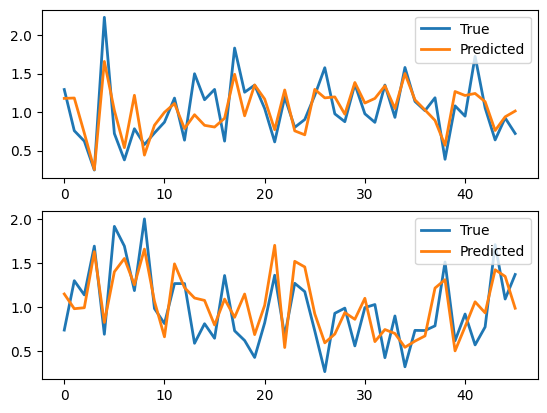

In [8]:
print('mse_test_1:', mse_test_1)
print('mse_test_2:', mse_test_2)
plt.subplot(2, 1, 1)
plt.plot(y_test_1, linewidth=2, label='True')
plt.plot(y_pred_test_1, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test_2, linewidth=2, label='True')
plt.plot(y_pred_test_2, linewidth=2, label='Predicted')
plt.legend()
plt.show()

Same: 133  Diff: 141
Same: 141  Diff: 133
MSE1: 0.19254762180201046
MSE2: 0.22626424108843113


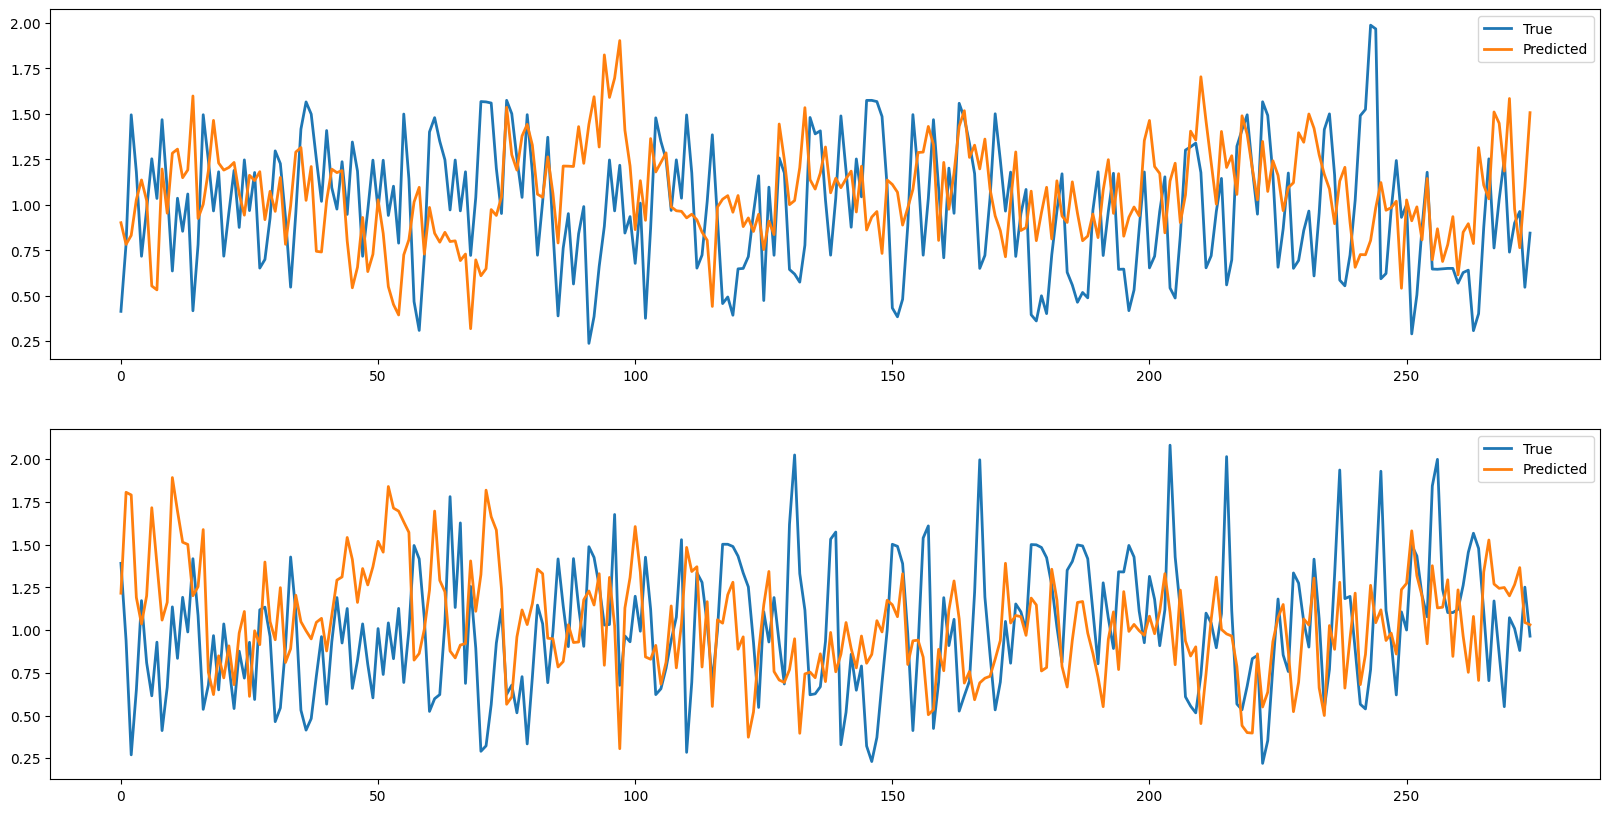

In [9]:
another_y_1 = another_Y[:,1]
another_y_2 = another_Y[:,0]
another_y_pred_1 = model1.predict(another_X_pca)
another_y_pred_2 = model2.predict(another_X_pca)

another_diff_sign_pred_1 = np.sign(np.diff(np.array(another_y_pred_1)))
another_diff_sign_pred_2 = np.sign(np.diff(np.array(another_y_pred_2)))
another_diff_sign_1 = np.sign(np.diff(np.array(another_y_1)))
another_diff_sign_2 = np.sign(np.diff(np.array(another_y_2)))
another_same_1 = np.sum(another_diff_sign_pred_1 == another_diff_sign_1)
another_diff_1 = np.sum(another_diff_sign_pred_1 != another_diff_sign_1)
another_same_2 = np.sum(another_diff_sign_pred_2 == another_diff_sign_2)
another_diff_2 = np.sum(another_diff_sign_pred_2 != another_diff_sign_2)
print('Same:',another_same_1, ' Diff:', another_diff_1)
print('Same:',another_same_2, ' Diff:', another_diff_2)
print('MSE1:', mean_squared_error(another_y_1, another_y_pred_1))
print('MSE2:', mean_squared_error(another_y_2, another_y_pred_2))


plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(another_y_1, linewidth=2, label='True')
plt.plot(another_y_pred_1, linewidth=2, label='Predicted')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(another_y_2, linewidth=2, label='True')
plt.plot(another_y_pred_2, linewidth=2, label='Predicted')
plt.legend()
plt.show()


In [10]:
predict_train_1 = model1.predict(X_train_pca)
predict_train_2 = model2.predict(X_train_pca)
predict_all_1 = model1.predict(X_pca)
predict_all_2 = model2.predict(X_pca)
savedict = {"bestp":bestp,"predict_train_1":predict_train_1,"predict_train_2":predict_train_2,
            "pred_test_1":y_pred_test_1,"pred_test_2":y_pred_test_2,
            "another_y_pred_1":another_y_pred_1,"another_y_pred_2":another_y_pred_2,
            "predict_all_1":predict_all_1,"predict_all_2":predict_all_2,
            "y_train_1":y_train_1,"y_train_2":y_train_2,
            "y_test_1":y_test_1,"y_test_2":y_test_2,
            "another_y_1":another_y_1,"another_y_2":another_y_2,
}
MCM.save(savedict,'newbestresult')
            

In [11]:
the_end = 7300
all_match_data = num_data[0:the_end].copy()
for i in range(1,sum_days):
    all_match_data = all_match_data + num_data[i:the_end+i].reset_index(drop=True)
all_match_data['p1_m_avg'] = dict_data['p1_m_avg'][sum_days-1:the_end+sum_days-1]
all_match_data['p2_m_avg'] = dict_data['p2_m_avg'][sum_days-1:the_end+sum_days-1]
all_match_data['p1_m_gaussian'] = dict_data['p1_m_gaussian'][sum_days-1:the_end+sum_days-1]
all_match_data['p2_m_gaussian'] = dict_data['p2_m_gaussian'][sum_days-1:the_end+sum_days-1]
all_match_data['p1_next_m_avg'] = dict_data['p1_m_avg'][sum_days:the_end+sum_days]
all_match_data['p2_next_m_avg'] = dict_data['p2_m_avg'][sum_days:the_end+sum_days]
all_match_data['p1_next_m_gaussian'] = dict_data['p1_m_gaussian'][sum_days:the_end+sum_days]
all_match_data['p2_next_m_gaussian'] = dict_data['p2_m_gaussian'][sum_days:the_end+sum_days]
all_match_data['p1_avg_diff'] = dict_data['p1_m_avg'][sum_days:the_end+sum_days]-dict_data['p1_m_avg'][sum_days-1:the_end+sum_days-1]
all_match_data['p2_avg_diff'] = dict_data['p2_m_avg'][sum_days:the_end+sum_days]-dict_data['p2_m_avg'][sum_days-1:the_end+sum_days-1]
all_match_data['p1_gaussian_diff'] = dict_data['p1_m_gaussian'][sum_days:the_end+sum_days]-dict_data['p1_m_gaussian'][sum_days-1:the_end+sum_days-1]
all_match_data['p2_gaussian_diff'] = dict_data['p2_m_gaussian'][sum_days:the_end+sum_days]-dict_data['p2_m_gaussian'][sum_days-1:the_end+sum_days-1]
all_match_X = all_match_data[new_columns].to_numpy()
all_match_Y = all_match_data.iloc[:, -6:-4].to_numpy()
all_match_pre_1 = model1.predict(all_match_X)
all_match_pre_2 = model2.predict(all_match_X)
all_match_data['p1_pre'] = all_match_pre_1 
all_match_data['p2_pre'] = all_match_pre_2

In [12]:
MCM.save({'all_match_data':all_match_data},'new_all_match_data')
print(all_match_data.columns)

Index(['set_no', 'game_no', 'point_no', 'p1_sets', 'p2_sets', 'p1_games',
       'p2_games', 'p1_score', 'p2_score', 'server', 'serve_no',
       'point_victor', 'p1_points_won', 'p2_points_won', 'game_victor',
       'set_victor', 'p1_ace', 'p2_ace', 'p1_winner', 'p2_winner',
       'winner_shot_type', 'p1_double_fault', 'p2_double_fault', 'p1_unf_err',
       'p2_unf_err', 'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won',
       'p2_net_pt_won', 'p1_break_pt', 'p2_break_pt', 'p1_break_pt_won',
       'p2_break_pt_won', 'p1_break_pt_missed', 'p2_break_pt_missed',
       'p1_distance_run', 'p2_distance_run', 'rally_count', 'speed_mph',
       'serve_depth', 'return_depth', 'cost_time', 'p1_get_point',
       'p2_get_point', 'serve_width_1', 'serve_width_2', 'p1_m_avg',
       'p2_m_avg', 'p1_m_gaussian', 'p2_m_gaussian', 'p1_next_m_avg',
       'p2_next_m_avg', 'p1_next_m_gaussian', 'p2_next_m_gaussian',
       'p1_avg_diff', 'p2_avg_diff', 'p1_gaussian_diff', 'p2_gaussian_diff',
       'p1_p

In [13]:

#建立dataframe,以model1.feature_importances_为第一行，model2.feature_importances_为第二行，new_columns为列名
df = pd.DataFrame([model1.feature_importances_,model2.feature_importances_],columns=new_columns)
new_columns.shape

(40,)